In [1]:
import pytorch_lightning as pl
pl.seed_everything(10)

from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import torchvision

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F

from dataset.digit import ChanDup, CENDataset
from pl_module.zsgcada import LitZSGCADA

Global seed set to 10


In [2]:
class ZSGCADAConfig:
    checkpoint_filename = [
        "zsgcada-lenet-epoch=05-task=digit-val_loss_tgt=1.4880.ckpt",
    ]
    lambda_noise: None
    device="cuda:1"
    
    root="/shared/lorenzo/mnist-zsda/MNIST_G"
    root_tgt="/shared/lorenzo/mnist-zsda/MNIST_C"
    
    model_name="zsgcada"
    backbone_name="lenet"
    
    root_tgt_train="/shared/lorenzo/mnist-zsda/FashionMNIST_C"
    num_blocks=9
    hidden_dim_dsc=32
    lambda_idt=1.0
    lambda_sem=0.0
    transformation="rotate"
    beta1=0.5
    pretrained="/root/dezsda/checkpoints/timm-lenet-epoch=03-task=digit-val_loss=0.0297.ckpt"
    fix_block_up=False
    lambda_sem_idt=10.0
    sem_idt_per_epoch=1
    
    lr_enc_multi: 1.0
    lr_dsc_multi: 1.0
    lambda_rec: 1.0
    lambda_cross: 1.0

    lr = 1e-3
    optimizer = "adam"
    batch_size = 64
    max_epochs = 50
    grad_accum = 1
    es_patience = None
    task="digit"
    img_size = 28
    fold_no = 0
    num_workers = 8
    channels = 3
    logger = True
    seed = 42
    project = "csi-har"
    checkpoint_dir = "/root/dezsda/checkpoints"
    gpus = 1
    num_classes=10
    num_test_sets=4

    assert root.split("/")[-1].split("_")[0] == root_tgt.split("/")[-1].split("_")[0]
    translated_dir=f"/shared/lorenzo/mnist-zsda/{root.split('/')[-1].split('_')[0]}_{root.split('/')[-1].split('_')[-1]}{root_tgt.split('/')[-1].split('_')[-1]}"
    
config = ZSGCADAConfig()

In [3]:
cf = config.checkpoint_filename[0]
pl_model = LitZSGCADA.load_from_checkpoint(f"/shared/lorenzo/checkpoints/{cf}", config=config)
model = pl_model.model
model.eval()
None

FileNotFoundError: [Errno 2] No such file or directory: '/shared/lorenzo/checkpoints/zsgcada-lenet-epoch=05-task=digit-val_loss_tgt=1.4880.ckpt'

In [4]:
transform = transforms.Compose([
    # transforms.Resize(32),
    transforms.CenterCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    ChanDup(),
])

dataset_mnist_g = datasets.MNIST(root="/shared/lorenzo/mnist-zsda/MNIST_G", train=True, transform=transform)
dataset_fashionmnist_c = CENDataset(root="/shared/lorenzo/mnist-zsda/FashionMNIST_C", train=True, transform=transform)

inputs_mnist_g, _ = dataset_mnist_g[0]
inputs_mnist_g = inputs_mnist_g.unsqueeze(0)

inputs_fashionmnist_c, _ = dataset_fashionmnist_c[0]
inputs_fashionmnist_c = inputs_fashionmnist_c.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


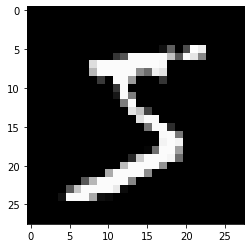

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


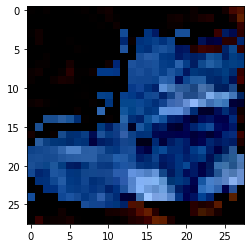

In [5]:
plt.imshow(inputs_mnist_g[0].permute(1,2,0))
plt.show()

plt.imshow(inputs_fashionmnist_c[0].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


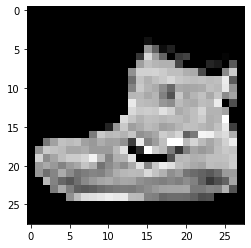

In [12]:
dataset_emnist_g = torchvision.datasets.FashionMNIST(root="/shared/lorenzo/mnist-zsda/FashionMNIST_G", train=True, transform=transform)

inputs_emnist_g, _ = dataset_emnist_g[0]
inputs_emnist_g = inputs_emnist_g.unsqueeze(0)
plt.imshow(inputs_emnist_g[0].permute(1,2,0))
plt.show()

In [6]:
x_toi, x_src = model.get_feature(inputs_mnist_g)
x_irt, x_tgt = model.get_feature(inputs_fashionmnist_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


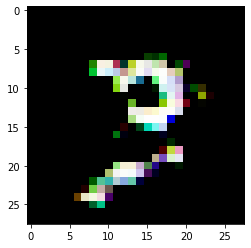

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


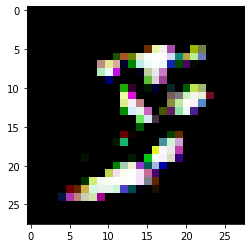

In [8]:
inputs_fashionmnist_g_syn = model.forward_up(x_irt, x_src)
inputs_mnist_c_syn = model.forward_up(x_toi, x_tgt)

plt.imshow(inputs_fashionmnist_g_syn.detach()[0].permute(1,2,0))
plt.show()

plt.imshow(inputs_mnist_c_syn.detach()[0].permute(1,2,0))
plt.show()

In [4]:
transform = transforms.Compose([
    # transforms.Resize(32),
    transforms.CenterCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    ChanDup(),
])

dataset = CENDataset(root=config.root_tgt_train, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=config.batch_size,
                        shuffle=True, pin_memory=True, 
                        num_workers=config.num_workers, drop_last=True)

model = model.to(config.device)
domain_invariant_features_irt_tgt = None
class_invariant_features_irt_tgt = None
combined_features_irt_tgt = None
targets_irt_tgt = None
for batch in tqdm(dataloader):
    inputs_src, targets_src = batch
    inputs_src = inputs_src.to(config.device)
    targets_src = targets_src.to(config.device)

    x_c, x_b = model.get_feature(inputs_src)
    domain_invariant_feature = F.avg_pool2d(x_c, x_b.size()[2:])[:,:,0,0]
    class_invariant_feature = F.avg_pool2d(x_b, x_b.size()[2:])[:,:,0,0]
    combined_feature = F.avg_pool2d(x_c+x_b, x_b.size()[2:])[:,:,0,0]

    if domain_invariant_features_irt_tgt is not None:
        domain_invariant_features_irt_tgt = torch.cat([domain_invariant_feature.detach(), domain_invariant_features_irt_tgt], dim=0)
        class_invariant_features_irt_tgt = torch.cat([class_invariant_feature.detach(), class_invariant_features_irt_tgt], dim=0)
        combined_features_irt_tgt = torch.cat([combined_feature.detach(), combined_features_irt_tgt], dim=0)
        targets_irt_tgt = torch.cat([targets_src, targets_irt_tgt], dim=0)
    else:
        domain_invariant_features_irt_tgt = domain_invariant_feature
        class_invariant_features_irt_tgt = class_invariant_feature
        combined_features_irt_tgt = combined_feature
        targets_irt_tgt = targets_src

    del domain_invariant_feature
    del class_invariant_feature
    del combined_feature
    del targets_src

100%|██████████| 937/937 [00:16<00:00, 55.51it/s]


In [5]:
transform = transforms.Compose([
    # transforms.Resize(32),
    transforms.CenterCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    ChanDup(),
])

dataset = datasets.MNIST(root=config.root, train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=config.batch_size,
                        shuffle=True, pin_memory=True, 
                        num_workers=config.num_workers, drop_last=True)

model = model.to(config.device)
domain_invariant_features_toi_src = None
class_invariant_features_toi_src = None
combined_features_toi_src = None
targets_toi_src = None
for batch in tqdm(dataloader):
    inputs_src, targets_src = batch
    inputs_src = inputs_src.to(config.device)
    targets_src = targets_src.to(config.device)

    x_c, x_b = model.get_feature(inputs_src)
    domain_invariant_feature = F.avg_pool2d(x_c, x_b.size()[2:])[:,:,0,0]
    class_invariant_feature = F.avg_pool2d(x_b, x_b.size()[2:])[:,:,0,0]
    combined_feature = F.avg_pool2d(x_c+x_b, x_b.size()[2:])[:,:,0,0]

    if domain_invariant_features_toi_src is not None:
        domain_invariant_features_toi_src = torch.cat([domain_invariant_feature.detach(), domain_invariant_features_toi_src], dim=0)
        class_invariant_features_toi_src = torch.cat([class_invariant_feature.detach(), class_invariant_features_toi_src], dim=0)
        combined_features_toi_src = torch.cat([combined_feature.detach(), combined_features_toi_src], dim=0)
        targets_toi_src = torch.cat([targets_src, targets_toi_src], dim=0)
    else:
        domain_invariant_features_toi_src = domain_invariant_feature
        class_invariant_features_toi_src = class_invariant_feature
        combined_features_toi_src = combined_feature
        targets_toi_src = targets_src

    del domain_invariant_feature
    del class_invariant_feature
    del combined_feature
    del targets_src

100%|██████████| 937/937 [00:16<00:00, 58.38it/s]


In [6]:
transform = transforms.Compose([
    # transforms.Resize(32),
    transforms.CenterCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    ChanDup(),
])

dataset = dataset = CENDataset(root=config.root_tgt, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=config.batch_size,
                        shuffle=True, pin_memory=True, 
                        num_workers=config.num_workers, drop_last=True)

model = model.to(config.device)
domain_invariant_features_test = None
class_invariant_features_test = None
combined_features_test = None
targets_test = None
for batch in tqdm(dataloader):
    inputs_src, targets_src = batch
    inputs_src = inputs_src.to(config.device)
    targets_src = targets_src.to(config.device)

    x_c, x_b = model.get_feature(inputs_src)
    domain_invariant_feature = F.avg_pool2d(x_c, x_b.size()[2:])[:,:,0,0]
    class_invariant_feature = F.avg_pool2d(x_b, x_b.size()[2:])[:,:,0,0]
    combined_feature = F.avg_pool2d(x_c+x_b, x_b.size()[2:])[:,:,0,0]

    if domain_invariant_features_test is not None:
        domain_invariant_features_test = torch.cat([domain_invariant_feature.detach(), domain_invariant_features_test], dim=0)
        class_invariant_features_test = torch.cat([class_invariant_feature.detach(), class_invariant_features_test], dim=0)
        combined_features_test = torch.cat([combined_feature.detach(), combined_features_test], dim=0)
        targets_test = torch.cat([targets_src, targets_test], dim=0)
    else:
        domain_invariant_features_test = domain_invariant_feature
        class_invariant_features_test = class_invariant_feature
        combined_features_test = combined_feature
        targets_test = targets_src

    del domain_invariant_feature
    del class_invariant_feature
    del combined_feature

100%|██████████| 937/937 [00:15<00:00, 58.57it/s]


In [7]:
y_toi_src = targets_toi_src.cpu().detach().numpy()[:1000].astype(str).tolist()
y_test = targets_test.cpu().detach().numpy()[:1000].astype(str).tolist()

In [8]:
domain_invariant_features_irt_tgt = domain_invariant_features_irt_tgt.cpu().detach().numpy()[:1000]
domain_invariant_features_toi_src = domain_invariant_features_toi_src.cpu().detach().numpy()[:1000]
domain_invariant_features_test = domain_invariant_features_test.cpu().detach().numpy()[:1000]

X = np.concatenate([
    domain_invariant_features_irt_tgt, 
    domain_invariant_features_toi_src, 
    domain_invariant_features_test,
], axis=0)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random').fit_transform(X)

df = pd.DataFrame(X_embedded)
df["group"] = ["tgt_train (FashionMNIST_C)"] * 1000 + ["src_train (MNIST_G)"] * 1000 +["tgt_test (MNIST_C)"] * 1000
df["target"] = ["-"] * 1000 + y_toi_src + y_test

plt.rcParams["figure.figsize"] = (20,20)
sns.scatterplot(data=df, x=0, y=1, hue="group", s=400)
plt.legend(markerscale=3, fontsize=18)
plt.savefig(f"domain_invariant_{cf}.group.png")
plt.clf()

plt.rcParams["figure.figsize"] = (20,20)
sns.scatterplot(data=df, x=0, y=1, hue="target", s=400, style="group")
plt.legend(markerscale=3, fontsize=18)
plt.savefig(f"domain_invariant_{cf}.class.png")
plt.clf()

<Figure size 1440x1440 with 0 Axes>

In [9]:
class_invariant_features_toi_src = class_invariant_features_toi_src.detach().cpu().numpy()[:1000]
class_invariant_features_irt_tgt = class_invariant_features_irt_tgt.detach().cpu().numpy()[:1000]
class_invariant_features_test = class_invariant_features_test.detach().cpu().numpy()[:1000]

X = np.concatenate([
    class_invariant_features_toi_src,
    class_invariant_features_irt_tgt,
    class_invariant_features_test,
], axis=0)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random').fit_transform(X)

df = pd.DataFrame(X_embedded)
df["group"] = ["tgt_train (FashionMNIST_C)"] * 1000 + ["src_train (MNIST_G)"] * 1000 +["tgt_test (MNIST_C)"] * 1000
df["target"] = ["-"] * 1000 + y_toi_src + y_test

plt.rcParams["figure.figsize"] = (20,20)
sns.scatterplot(data=df, x=0, y=1, hue="group", s=400)
plt.legend(markerscale=3, fontsize=18)
plt.savefig(f"class_invariant_{cf}.group.png")
plt.clf()

plt.rcParams["figure.figsize"] = (20,20)
sns.scatterplot(data=df, x=0, y=1, hue="target", s=400, style="group")
plt.legend(markerscale=3, fontsize=18)
plt.savefig(f"class_invariant_{cf}.class.png")
plt.clf()

<Figure size 1440x1440 with 0 Axes>

In [10]:
combined_features_irt_tgt = combined_features_irt_tgt.detach().cpu().numpy()[:1000]
combined_features_toi_src = combined_features_toi_src.detach().cpu().numpy()[:1000]
combined_features_test = combined_features_test.detach().cpu().numpy()[:1000]

X = np.concatenate([
    combined_features_irt_tgt,
    combined_features_toi_src,
    combined_features_test,
], axis=0)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random').fit_transform(X)

df = pd.DataFrame(X_embedded)
df["group"] = ["tgt_train (FashionMNIST_C)"] * 1000 + ["src_train (MNIST_G)"] * 1000 +["tgt_test (MNIST_C)"] * 1000

plt.rcParams["figure.figsize"] = (20,20)
sns.scatterplot(data=df, x=0, y=1, hue="group", s=400)
plt.legend(markerscale=3, fontsize=18)
plt.savefig(f"combined_{cf}.group.png")
plt.clf()

plt.rcParams["figure.figsize"] = (20,20)
sns.scatterplot(data=df, x=0, y=1, hue="target", s=400, style="group")
plt.legend(markerscale=3, fontsize=18)
plt.savefig(f"combined_{cf}.class.png")
plt.clf()

ValueError: Could not interpret value `target` for parameter `hue`

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# for cf in config.checkpoint_filename:
#     pl_model = LitZSGCADA.load_from_checkpoint(f"./checkpoints/{cf}", config=config)
#     model = pl_model.model
#     model.eval()

#     transform = transforms.Compose([
#         # transforms.Resize(32),
#         transforms.CenterCrop((28, 28)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.5], std=[0.5]),
#         ChanDup(),
#     ])

#     dataset = CENDataset(root=config.root_tgt_train, train=True, transform=transform)
#     dataloader = DataLoader(dataset, batch_size=config.batch_size,
#                             shuffle=True, pin_memory=True, 
#                             num_workers=config.num_workers, drop_last=True)

#     model = model.to(config.device)
#     translated_inputs_tgt = None
#     translated_targets_tgt = None
#     for batch in tqdm(dataloader):
#         inputs_src, targets_src = batch
#         inputs_src = inputs_src.to(config.device)
#         targets_src = targets_src.to(config.device)

#         x_c, x_b = model.get_feature(inputs_src)
#         outputs = F.avg_pool2d(x_c + x_b, x_b.size()[2:])[:,:,0,0]

#         if translated_inputs_tgt is not None:
#             translated_inputs_tgt = torch.cat([outputs.detach(), translated_inputs_tgt], dim=0)
#             translated_targets_tgt = torch.cat([targets_src.detach(), translated_targets_tgt], dim=0)
#         else:
#             translated_inputs_tgt = outputs
#             translated_targets_tgt = targets_src

#         del outputs
#         del targets_src

#     dataset = datasets.MNIST(root=config.root, train=True, download=True, transform=transform)
#     dataloader = DataLoader(dataset, batch_size=config.batch_size,
#                             shuffle=True, pin_memory=True, 
#                             num_workers=config.num_workers, drop_last=True)

#     model = model.to(config.device)
#     translated_inputs_src = None
#     translated_targets_src = None
#     for batch in tqdm(dataloader):
#         inputs_src, targets_src = batch
#         inputs_src = inputs_src.to(config.device)
#         targets_src = targets_src.to(config.device)

#         x_c, x_b = model.get_feature(inputs_src)
#         outputs = F.avg_pool2d(x_c + x_b, x_b.size()[2:])[:,:,0,0]

#         if translated_inputs_src is not None:
#             translated_inputs_src = torch.cat([outputs.detach(), translated_inputs_src], dim=0)
#             translated_targets_src = torch.cat([targets_src.detach(), translated_targets_src], dim=0)
#         else:
#             translated_inputs_src = outputs
#             translated_targets_src = targets_src

#         del outputs
#         del targets_src

#     dataset = CENDataset(root=config.root_tgt, train=True, transform=transform)
#     dataloader = DataLoader(dataset, batch_size=config.batch_size,
#                             shuffle=True, pin_memory=True, 
#                             num_workers=config.num_workers, drop_last=True)

#     model = model.to(config.device)
#     translated_inputs_tgt_test = None
#     translated_targets_tgt_test = None
#     for batch in tqdm(dataloader):
#         inputs_src, targets_src = batch
#         inputs_src = inputs_src.to(config.device)
#         targets_src = targets_src.to(config.device)

#         x_c, x_b = model.get_feature(inputs_src)
#         outputs = F.avg_pool2d(x_c + x_b, x_b.size()[2:])[:,:,0,0]

#         if translated_inputs_tgt_test is not None:
#             translated_inputs_tgt_test = torch.cat([outputs.detach(), translated_inputs_tgt_test], dim=0)
#             translated_targets_tgt_test = torch.cat([targets_src.detach(), translated_targets_tgt_test], dim=0)
#         else:
#             translated_inputs_tgt_test = outputs
#             translated_targets_tgt_test = targets_src

#         del outputs
#         del targets_src

#     X_tgt = translated_inputs_tgt.cpu().detach().numpy()[:1000]
#     X_src = translated_inputs_src.cpu().detach().numpy()[:1000]
#     X_tgt_test = translated_inputs_tgt_test.cpu().detach().numpy()[:1000]

#     _ = translated_targets_tgt.cpu().detach().numpy()[:1000].astype(str).tolist()
#     y_src = translated_targets_src.cpu().detach().numpy()[:1000].astype(str).tolist()
#     y_tgt_test = translated_targets_tgt_test.cpu().detach().numpy()[:1000].astype(str).tolist()

#     X = np.concatenate([X_tgt, X_src, X_tgt_test], axis=0)
#     X_embedded = TSNE(n_components=2, learning_rate='auto',
#                     init='random').fit_transform(X)

#     df = pd.DataFrame(X_embedded)
#     df["group"] = ["tgt_train (FashionMNIST_C)"] * 1000 + ["src_train (MNIST_G)"] * 1000 +["tgt_test (MNIST_C)"] * 1000
#     df["target"] = ["-"] * 1000 + y_src + y_tgt_test

#     plt.rcParams["figure.figsize"] = (20,20)
#     sns.scatterplot(data=df, x=0, y=1, hue="group", s=400)
#     plt.legend(markerscale=3, fontsize=18)
#     plt.savefig(f"{cf}.group.png")
#     plt.clf()
    

#     plt.rcParams["figure.figsize"] = (20,20)
#     sns.scatterplot(data=df, x=0, y=1, hue="target", s=400, style="group")
#     plt.legend(markerscale=3, fontsize=18)
#     plt.savefig(f"{cf}.class.png")
#     plt.clf()